# Curve Fitting in Planetary Data Analysis

Curve fitting is essential for modeling relationships between variables. It helps with tasks like identifying trends in data, noise reduction, and extrapolating missing or uncertain data points.


# Polynomial Regression for Curve Fitting

Polynomial regression fits a polynomial curve to data by extending the linear regression model to higher powers of the input features. It is commonly used when the relationship between variables is non-linear.

## Polynomial Regression Formula:
#### $y = b_0 + b_1*x + b_2*x^2 + ... + b_n*x^n$

Polynomial regression is often used when an underlying physical equation is either unknown or not necessary (for example fitting to an absoprtion band... we know a polynomial isn't the underlying physical law governing the data, but it's good enough to do what we want).


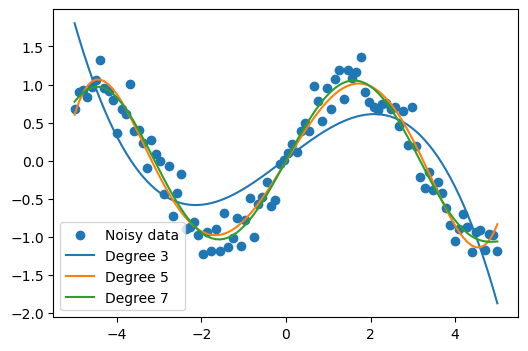

Best fit is degree 7
[48.76785408839572, 17.261590984841455, 4.227051097129371]


In [3]:
# Example: Polynomial Regression with scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Generate synthetic data
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(x) + 0.2 * np.random.normal(size=x.shape)

# Polynomial regression model (degree 3)
deg_list = [3, 5, 7]
chi2_list = []
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='Noisy data')

for deg in deg_list:
    '''
    PolynomialFeatures(degree=deg):
        Create an instance of the PolynomialFeatures class from scikit-learn.
        The degree parameter specifies the degree of the polynomial features to be generated. 
        For example, if deg is 2, it will generate features like (x, x^2).
        This transformer is used to create new features by taking polynomial combinations 
        of the original features.
    
    LinearRegression():
        Create an instance of the LinearRegression class from scikit-learn.
        It represents a linear regression model that will be used to fit the 
        transformed polynomial features.

        Why Fit Again?
            The original data is not directly fit to the linear regression model. 
            Instead, the polynomial transformation creates new features that capture 
            the non-linear relationships. The linear regression model is then fit to 
            these new features.
    
    make_pipeline(...):
        This function constructs a pipeline from the given estimators.
        The pipeline sequentially applies a list of transforms and a final estimator.
        In this case, the pipeline first applies PolynomialFeatures to transform the input data, 
        and then applies LinearRegression to fit the transformed data.
    
    model = ...:
        The resulting pipeline is assigned to the variable model.
        This model can now be used to fit data, make predictions, 
        and perform other operations as a single object.
    '''
    model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model.fit(x, y)
    
    y_pred = model.predict(x)
    
    # calculate the best fit with chi2
    chi2 = np.abs(np.sum((y - y_pred)**2 / y_pred))
    chi2_list.append(chi2)
    plt.plot(x, y_pred, label=f'Degree {deg}')
    plt.legend()

plt.show()

best_fit = deg_list[np.argmin(chi2_list)]
print(f"Best fit is degree {best_fit}")
print(chi2_list)


# Parameter contraint
### fitting a known law to data, optimizing for parameter values
### Example: Crater size frequency distribution
$N(D) = k * D^{-m}$ –> crater size frequency distribution relation  

$k$: constant related to the impact flux  
$m$: is the slope of the distribution  
$D$: crater diameter  

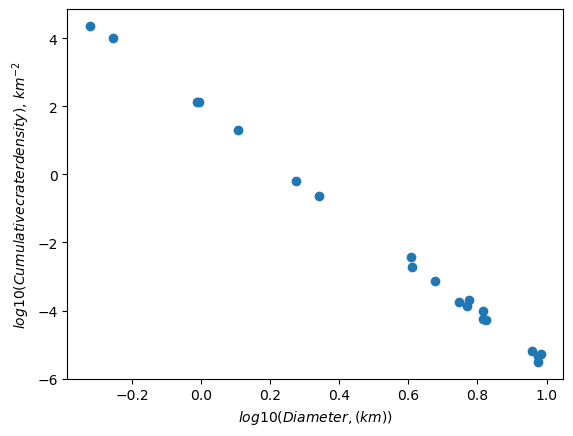

In [20]:
# parameters
k = 1e2
m = 7.5

# Generate synthetic data
xD = np.sort(np.random.uniform(0.3, 10, 20))
noise = np.array([np.random.normal(0, 0.05, 1)[0] * d for d in xD])
y = k * (xD + noise)**(-m)

# log transform
xD = np.log10(xD)
y = np.log10(y)

# Plot
plt.plot(xD, y, 'o')
plt.xlabel('$log10(Diameter, (km))$')
plt.ylabel('$log10(Cumulative crater density)$, $km^{-2}$')
plt.show()

In [21]:
# Fit line to predictions to extract k and m
def get_k_m(x, y):
    coeffs = np.polyfit(x.flatten(), y.flatten(), 1)
    m = -coeffs[0]  # Negative slope gives m
    k = 10 ** (coeffs[1])  # y-intercept gives log10(k)
    
    return k, m

k_pred, m_pred = get_k_m(xD, y)
print(f"Predicted k: {k_pred}, Predicted m: {m_pred}")

Predicted k: 103.90329543446376, Predicted m: 7.562916008582907


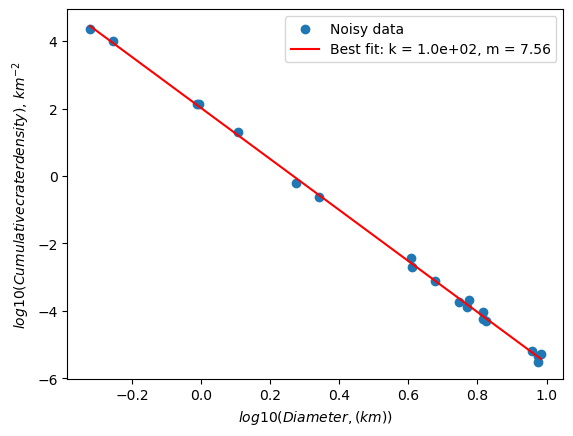

In [23]:
csfd = lambda x: np.log10(k_pred) - m_pred * x
yfit = csfd(xD)
plt.scatter(xD, y, label='Noisy data')
plt.plot(xD, yfit, 'r', label=f'Best fit: k = {k_pred:.1e}, m = {m_pred:.2f}')
plt.xlabel('$log10(Diameter, (km))$')
plt.ylabel('$log10(Cumulative crater density)$, $km^{-2}$')
plt.legend()
plt.show()


In [24]:
# Fit line to predictions to extract k and m with weighting
def get_k_m_weighted(x, y):
    # Define weights inversely proportional to x values
    weights = 1 / (np.exp(x.flatten()) + 1e-6)  # Adding a small value to avoid division by zero
    sm_weights = np.exp(weights) / np.sum(np.exp(weights))
    
    # Perform weighted polynomial fit
    coeffs = np.polyfit(x.flatten(), y.flatten(), 1, w=sm_weights)
    m = -coeffs[0]  # Negative slope gives m
    k = 10 ** (coeffs[1])  # y-intercept gives log10(k)
    
    return k, m, weights

k_pred_weighted, m_pred_weighted, weights = get_k_m_weighted(xD, y)
print(f"Predicted k (weighted): {k_pred_weighted}, Predicted m (weighted): {m_pred_weighted}")

Predicted k (weighted): 103.68213732339734, Predicted m (weighted): 7.559706359039407


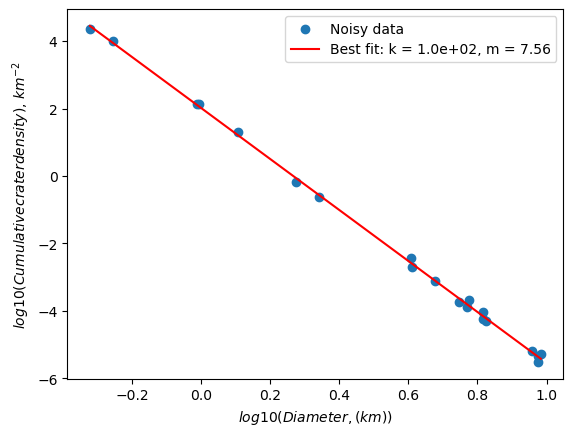

In [25]:
csfd = lambda x: np.log10(k_pred_weighted) - m_pred_weighted * x
yfit = csfd(xD)
plt.scatter(xD, y, label='Noisy data')
plt.plot(xD, yfit, 'r', label=f'Best fit: k = {k_pred_weighted:.1e}, m = {m_pred_weighted:.2f}')
plt.xlabel('$log10(Diameter, (km))$')
plt.ylabel('$log10(Cumulative crater density)$, $km^{-2}$')
plt.legend()
plt.show()


# Multilayer Perceptrons (MLPs) in Curve Fitting

A Multilayer Perceptron (MLP) is a type of neural network useful for approximating complex functions. MLPs are fully connected networks - meaning each node in the network is connected to every node in the previous and next layer. Unlike polynomial or linear regression, MLPs can model highly non-linear relationships.

![SegmentLocal](/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/Code/02_Curve_Fitting/files/mlp.gif)

A great description of MLPs is found in the following video: [3Blue1Brown Neural Networks Playlist](https://www.youtube.com/watch?v=aircAruvnKk).


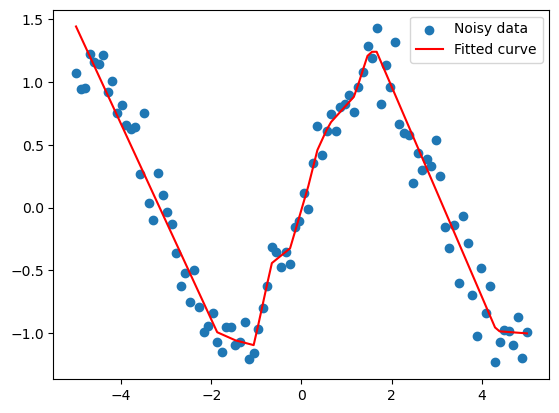

In [27]:
# Example: Training an MLP for Curve Fitting

# We will fit an MLP to noisy sinusoidal data using PyTorch (you can use TensorFlow as an alternative).
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generating noisy data
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(x) + 0.2 * np.random.normal(size=x.shape)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, hu):
        super(MLP, self).__init__()
        self.input = nn.Linear(1, hu)
        self.normalize = nn.BatchNorm1d(hu)
        self.hidden = nn.Linear(hu, hu)
        self.output = nn.Linear(hu, 1)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = self.normalize(x)
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

# Prepare data for training
hidden_units = 16
model = MLP(hidden_units)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert numpy arrays to torch tensors
x_train = torch.tensor(x, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Training loop
for epoch in range(1000):
    model.train()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot results
plt.scatter(x, y, label='Noisy data')
plt.plot(x, model(x_train).detach().numpy(), label='Fitted curve', color='red')
plt.legend()
plt.show()


# Case Study: CRISM Noise Remediation

In planetary science, CRISM data (Compact Reconnaissance Imaging Spectrometer for Mars) can be noisy due to instrumental effects. MLPs can be used to fit curves to spectral data, modeling and removing noise for better analysis of surface mineralogy.

For further exploration, students can access public CRISM datasets and apply MLPs for noise remediation.


```python
def mlp_correct(self):
        logger.info('Setting up training data...')
        self.setup_training_data()
        logger.info('Beginning model fit...')
        regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=[32, 32]).fit(self.train_x, self.train_y)
        logger.info('Fit complete.')
        # metrics to see the quality of the fitting process and how the model generalizes:
        loss_orig = np.sqrt(np.mean(np.square(self.test_x1-self.test_y)))
        logger.info('Test Loss Before Correction: ' + str(loss_orig))
        loss_mlp = np.sqrt(np.mean(np.square(regr.predict(self.test_x)-self.test_y)))
        logger.info('Test Loss After MLP: ' + str(loss_mlp))
        loss_train_start = np.sqrt(np.mean(np.square(self.train_x1-self.train_y)))
        logger.info('Train loss start: ' + str(loss_train_start))
        loss_train_end = np.sqrt(np.mean(np.square(regr.predict(self.train_x)-self.train_y)))
        logger.info('Train loss end: ' + str(loss_train_end))
        
        # now to correct the HSP data:
        logger.info('Correcting HSP data...')
        # have to get rid of nans and then put them back in:
        sum_rows = np.sum(self.hsp_input, axis=1)
        not_nan = ~np.isnan(sum_rows)
        nan_vals = np.isnan(sum_rows)
        
        # nsamples x nfeatures
        inputs = self.hsp_input[not_nan, :]
        
        hsp_corrected = regr.predict(inputs)
    
        hsp_corrected_vec = np.zeros(self.hsp_vec.shape)
        hsp_corrected_vec[not_nan] = hsp_corrected
        crism_nan = 65535.0
        hsp_corrected_vec[nan_vals] = crism_nan
        hsp_corrected_cube = hsp_corrected_vec.reshape(self.all_hsp_data.shape)
        
        return hsp_corrected_cube
```

![surface fit](../files/SurfaceFit_v2.svg)
![output of transformed data.png](<attachment:output of transformed data.png>)

        
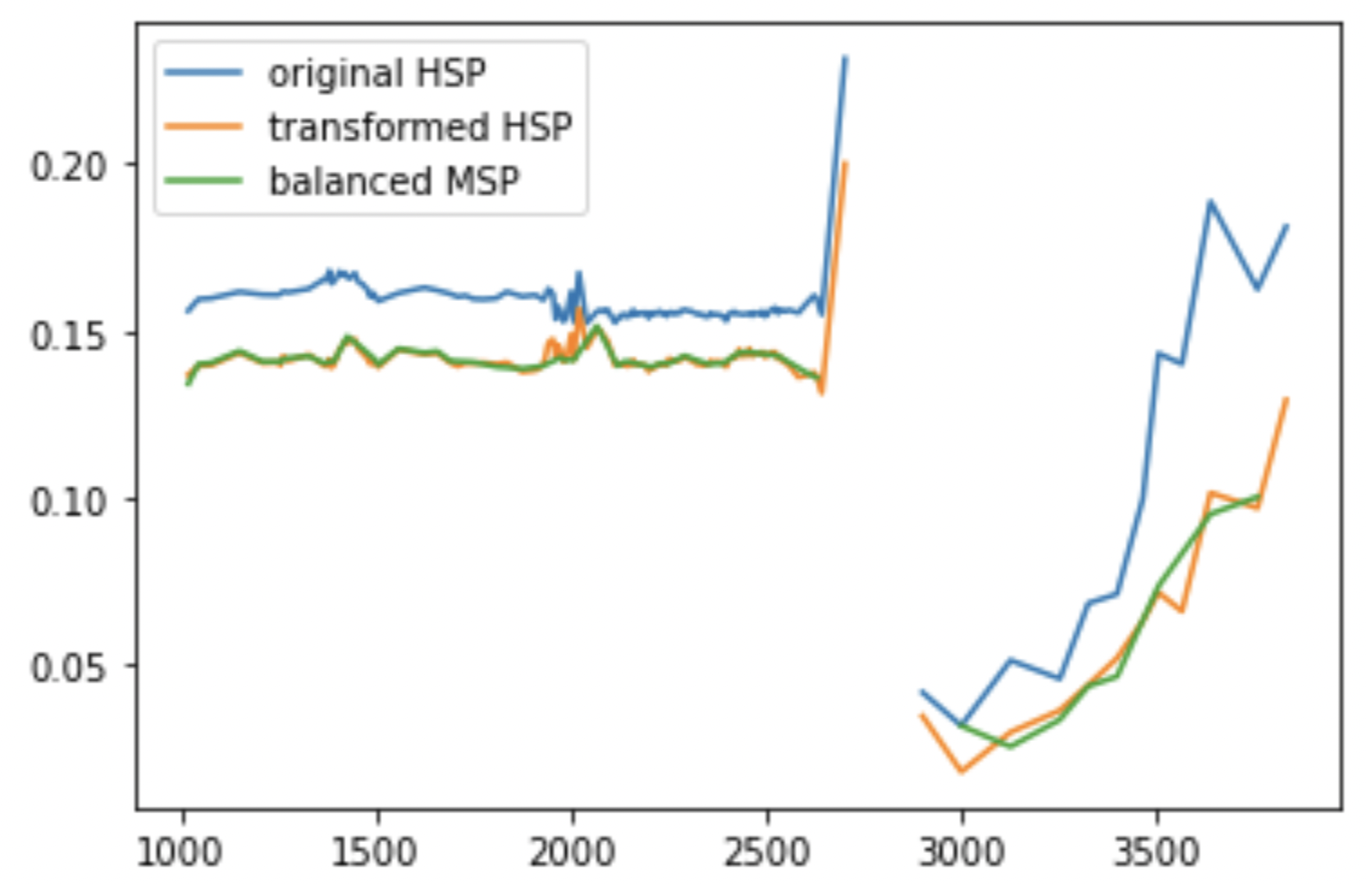

# Bayesian Neural Networks (BNNs) in Curve Fitting

Bayesian Neural Networks (BNNs) extend standard neural networks by placing probability distributions over the network weights. This allows BNNs to provide uncertainty estimates alongside predictions, which is useful in planetary science when dealing with noisy or incomplete data.  
[MC Dropout paper on Arxiv](https://arxiv.org/pdf/1506.02142)


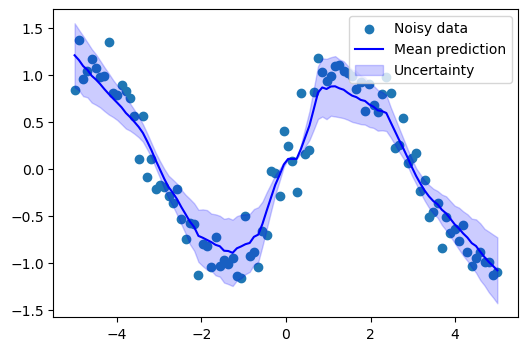

In [35]:
# Example: BNN Approximation with MC Dropout

# MC Dropout: A technique for approximating BNNs by enabling dropout during prediction, simulating a Bayesian-like model.

# We'll modify the MLP model from before to use dropout layers.

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generating noisy data
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(x) + 0.2 * np.random.normal(size=x.shape)

# Define MLP model
class MLP_DO(nn.Module):
    def __init__(self, hu):
        super(MLP_DO, self).__init__()
        self.input = nn.Linear(1, hu)
        self.normalize = nn.BatchNorm1d(hu)
        self.hidden = nn.Linear(hu, hu)
        self.do = nn.Dropout(0.5)
        self.output = nn.Linear(hu, 1)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = self.normalize(x)
        x = torch.relu(self.hidden(x))
        x = self.do(x)  
        x = self.output(x)
        return x

# Prepare data for training
hidden_units = 32
model = MLP_DO(hidden_units)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert numpy arrays to torch tensors
x_train = torch.tensor(x, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Training and prediction proceed similarly, but we’ll now use multiple forward passes to estimate uncertainty.
# Run multiple predictions (e.g., 100) to approximate the posterior distribution of predictions.

# Training loop
for epoch in range(10000):
    model.train()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# multiple forward passes to estimate uncertainty
y_preds = []
for _ in range(1000):
    y_pred = model(x_train)
    y_preds.append(y_pred.detach().numpy())

y_preds_mean = np.mean(y_preds, axis=0)
y_preds_std = np.std(y_preds, axis=0)

# Plot the mean prediction and uncertainty bounds
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='Noisy data')
plt.plot(x, y_preds_mean, label='Mean prediction', color='blue')
plt.fill_between(x.flatten(), y_preds_mean.flatten() - y_preds_std.flatten(), 
                 y_preds_mean.flatten() + y_preds_std.flatten(), color='blue', alpha=0.2, label='Uncertainty')
plt.legend()
plt.show()


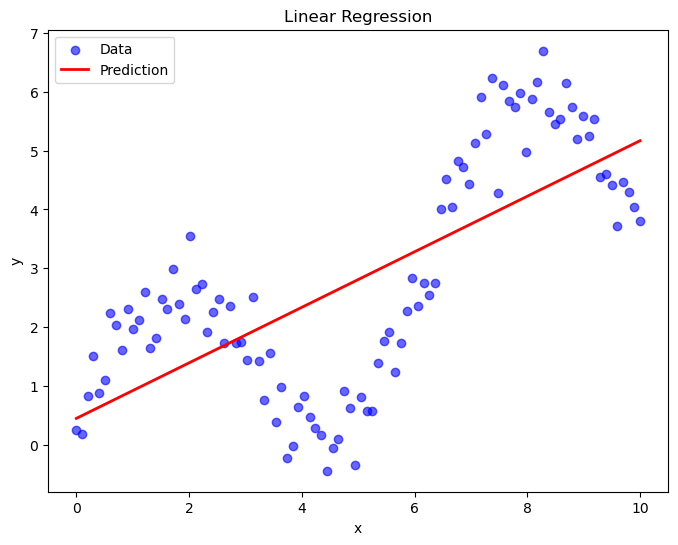

Linear Regression MSE: 1.9636


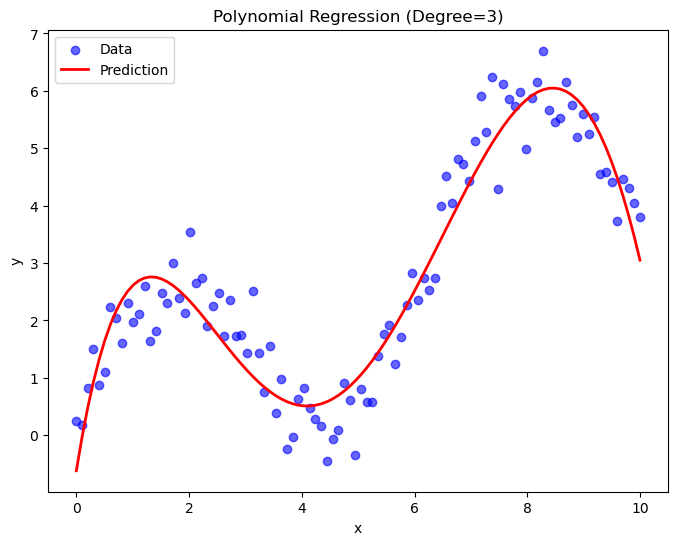

Polynomial Regression MSE: 0.3259


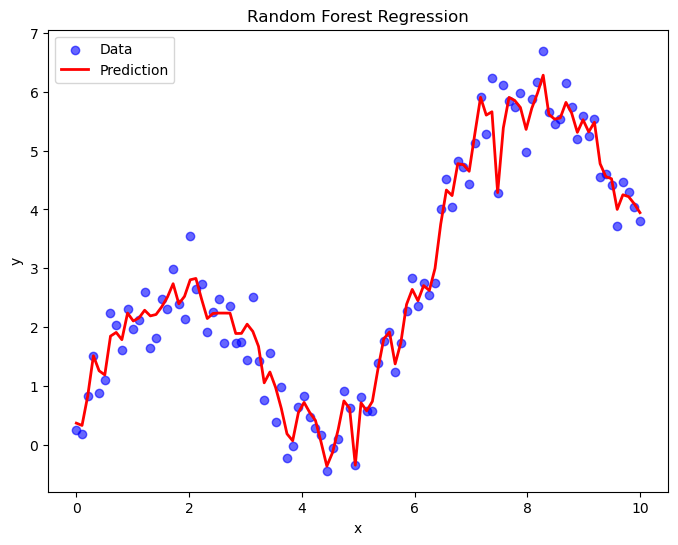

Random Forest Regression MSE: 0.0626


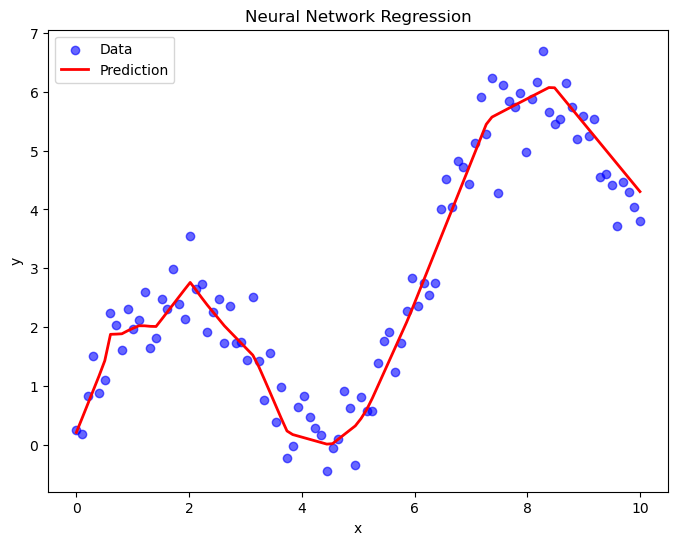

Neural Network Regression MSE: 0.1901

Summary of Techniques:
1. Linear Regression: Fits a straight line to the data. Best for linear relationships.
2. Polynomial Regression: Fits a polynomial curve to the data. Useful for capturing nonlinear trends.
3. Random Forest Regression: Uses an ensemble of decision trees for robust curve fitting. Effective for capturing complex patterns.
4. Neural Network Regression: Employs layers of neurons to approximate the target function. Ideal for highly nonlinear relationships but requires more data and tuning.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Generate synthetic data for demonstration
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * np.sin(x) + 0.5 * x + np.random.normal(scale=0.5, size=x.shape)

# Reshape x for compatibility with sklearn
x = x.reshape(-1, 1)

# Function to plot data and predictions
def plot_results(x, y, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="blue", label="Data", alpha=0.6)
    plt.plot(x, y_pred, color="red", label="Prediction", linewidth=2)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# 1. Linear Regression
linear_model = LinearRegression()
linear_model.fit(x, y)
y_pred_linear = linear_model.predict(x)
plot_results(x, y, y_pred_linear, "Linear Regression")
print(f"Linear Regression MSE: {mean_squared_error(y, y_pred_linear):.4f}")

# 2. Polynomial Regression (degree=3)
poly_features = PolynomialFeatures(degree=5)
x_poly = poly_features.fit_transform(x)
poly_model = LinearRegression()
poly_model.fit(x_poly, y)
y_pred_poly = poly_model.predict(x_poly)
plot_results(x, y, y_pred_poly, "Polynomial Regression (Degree=3)")
print(f"Polynomial Regression MSE: {mean_squared_error(y, y_pred_poly):.4f}")

# 3. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=5, random_state=42)
rf_model.fit(x, y)
y_pred_rf = rf_model.predict(x)
plot_results(x, y, y_pred_rf, "Random Forest Regression")
print(f"Random Forest Regression MSE: {mean_squared_error(y, y_pred_rf):.4f}")

# 4. Neural Network Regression (MLP)
hu = 64
hl = 64
mlp_model = MLPRegressor(hidden_layer_sizes=(hl,hu), max_iter=10000, random_state=42, learning_rate_init = 0.01, learning_rate = 'adaptive')
mlp_model.fit(x, y)
y_pred_mlp = mlp_model.predict(x)
plot_results(x, y, y_pred_mlp, "Neural Network Regression")
print(f"Neural Network Regression MSE: {mean_squared_error(y, y_pred_mlp):.4f}")

# Summary of techniques and their applications
print("""
Summary of Techniques:
1. Linear Regression: Fits a straight line to the data. Best for linear relationships.
2. Polynomial Regression: Fits a polynomial curve to the data. Useful for capturing nonlinear trends.
3. Random Forest Regression: Uses an ensemble of decision trees for robust curve fitting. Effective for capturing complex patterns.
4. Neural Network Regression: Employs layers of neurons to approximate the target function. Ideal for highly nonlinear relationships but requires more data and tuning.
""")
